# Introduction

Our ultimate aim is to predict solar electricity power generation over the next few hours.

## Loading terabytes of data efficiently from cloud storage

We have several TB of satellite data. To keep the GPU fed with data during training, we need to read chunks of data quickly from the Zarr store; and we also want to load data asynchronously.  That is, while the GPU is training on the current batch, the data loader should simultaneously load the _next_ batch from disk.

PyTorch makes this easy!  PyTorch's `DataLoader` spawns multiple worker processes when constructed with `num_workers` set to more than 1.  Each worker process receives a copy of the `SatelliteDataset` object.

There is a small challenge: The code hangs when it gets to `enumerate(dataloader)` if we open the `xarray.DataArray` in the main process and copy that opened `DataArray` to the child processes.  Our solution is to delay the creation of the `DataArray` until _after_ the worker processes have been created.  PyTorch makes this easy by allowing us to pass a `worker_init_fn` to `DataLoader`.  `worker_init_fn` is called on each worker process.  Our `worker_init_fn` just has one job: to call `SatelliteDataset.per_worker_init()` which, in turn, opens the `DataArray`.

This approach achieves read speeds of 600 MB/s from Google Cloud Storage to a single GCP VM with 12 vCPUs (as measured by `nethogs`).

We use `IterableDataset` instead of `Dataset` so `SatelliteDataset` can pre-load the next example from disk and then block (on the `yield`) waiting for PyTorch to read that data.  This allows the worker processes to be processing the next data samples while the main process is training the current batch on the GPU.

We can't pin the memory in each worker process because pinned memory can't be shared across processes.  Instead we ask `DataLoader` to pin the collated batch so that pytorch-lightning can asynchronously load the next batch from pinned CPU memory into GPU memory.

The satellite data is stored on disk as `int16`.  To speed up the movement of the satellite data between processes and from the CPU memory to the GPU memory, we keep the data as `int16` until the data gets to the GPU, where it is converted to `float32` and normalised.

### Loading data from disk into memory in chunks

Cloud storage buckets can't seek into files like 'proper' POSIX filesystems can.  So, even if we just want 1 byte from a 1 GB file, we have to load the entire 1 GB file from the bucket.  Zarr is specifically designed for cloud storage.  Zarr gets round the inability to seek into cloud storage objects by chunking the data into lots of small files.  But, still, we have to load entire Zarr chunks at once, even if we only want a part of each chunk.  And, even though we can pull 600 MB/s from a cloud storage bucket, the reads from the storage bucket are still the rate-limiting-step.  (GPUs are very fast!)

To get the most out of each disk read, our worker processes load several contiguous chunks of Zarr data from disk into memory in one go.  We then randomly sample from the in-memory data multiple times, before loading another set of chunks from disk into memory.

Each Zarr chunk is 36 timesteps long and contains the entire geographical extent.  Each timestep is ~5 minutes apart, so each Zarr chunk spans 1.5 hours, assuming the timesteps are contiguous.

### Loading only daylight data

We're interested in forecasting solar power generation, so we don't care about nighttime data :)

In the UK in summer, the sun rises first in the north east, and sets last in the north west (see [video of June 2019](https://www.youtube.com/watch?v=IOp-tj-IJpk&t=0s)).  In summer, the north gets more hours of sunshine per day.

In the UK in winter, the sun rises first in the south east, and sets last in the south west (see [video of Jan 2019](https://www.youtube.com/watch?v=CJ4prUVa2nQ)).  In winter, the south gets more hours of sunshine per day.

|                        | Summer | Winter |
|           ---:         |  :---: |  :---: |
| Sun rises first in     | N.E.   | S.E.   |
| Sun sets last in       | N.W.   | S.W.   |
| Most hours of sunlight | North  | South  |

We always load a pre-defined number of Zarr chunks from disk every disk load (defined by `n_chunks_per_disk_load`).

Before training, we run `pvlib.location.Location.get_clearsky(datetimes)` to tell us which timesteps are in complete darkness.  We compute the clearsky irradiance for all the timesteps in the dataset, and for the four corners of the satellite imagery.  We throw away timesteps where the minimum global horizontal irradiance (GHI) across all four corners is below threshold.

During training, we only load chunks which contain at least 1 daylight timestep.

## Timestep numbering:

* t<sub>0</sub> is 'now':  It's the most recent observation.
* t<sub>1</sub> is the first forecast.

In [38]:
# Python core
from typing import Optional, Callable, TypedDict, Union, Iterable, Tuple, NamedTuple
from dataclasses import dataclass
import datetime
from itertools import product

# Scientific python
import numpy as np
import pandas as pd
import xarray as xr
import numcodecs
import matplotlib.pyplot as plt

# Cloud compute
import gcsfs

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import pytorch_lightning as pl

# PV & geospatial
import pvlib
import pyproj

## Consts & config

The [Zarr docs](https://zarr.readthedocs.io/en/stable/tutorial.html#configuring-blosc) say we should tell the Blosc compression library not to use threads because we're using multiple processes to read from our Zarr store:

In [4]:
numcodecs.blosc.use_threads = False

ZARR = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr_int16'

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'none'

torch.cuda.is_available()

True

# Load satellite data

In [5]:
def get_sat_data(filename: str=ZARR) -> xr.DataArray:
    """Lazily opens the Zarr store on Google Cloud Storage (GCS).
    
    Selects the High Resolution Visible (HRV) satellite channel.
    """
    gcs = gcsfs.GCSFileSystem()
    store = gcsfs.GCSMap(root=filename, gcs=gcs)
    dataset = xr.open_zarr(store, consolidated=True)
    return dataset['stacked_eumetsat_data'].sel(variable='HRV')

In [6]:
%%time
sat_data = get_sat_data()

CPU times: user 1.94 s, sys: 111 ms, total: 2.05 s
Wall time: 4.62 s


Caution: Wierdly, plotting `sat_data` at this point causes the code to hang (with no errors messages) when it gets to `enumerate(dataloader)`.  The code hangs even if we first do `sat_data.close(); del sat_data`

In [7]:
sat_data

<xarray.DataArray 'stacked_eumetsat_data' (time: 163079, y: 704, x: 548)>
dask.array<getitem, shape=(163079, 704, 548), dtype=int16, chunksize=(36, 704, 548), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2018-06-01T02:04:00 ... 2019-12-31T22:54:00
    variable  <U6 'HRV'
  * x         (x) int64 -238000 -236000 -234000 -232000 ... 852000 854000 856000
  * y         (y) int64 1222000 1220000 1218000 ... -180000 -182000 -184000

Get the timestep indicies of each Zarr chunk.  Later, we will use these boundaries to ensure we load complete chunks at a time.

In [153]:
zarr_chunk_boundaries = np.concatenate(([0], np.cumsum(sat_data.chunks[0])))

## Geospatial

In [8]:
# OSGB is also called "OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey".
# OSGB is used in many UK electricity system maps, and is used by the UK Met Office UKV model.
# OSGB is a Transverse Mercator projection, using 'easting' and 'northing' coordinates
# which are in meters.
OSGB = 27700

# WGS84 is short for "World Geodetic System 1984", used in GPS. Uses latitude and longitude.
WGS84 = 4326

# osgb_to_wgs84.transform() returns latitude (north-south), longitude (east-west)
osgb_to_wgs84 = pyproj.Transformer.from_crs(crs_from=OSGB, crs_to=WGS84)


def get_daylight_timestamps(
    dt_index: pd.DatetimeIndex, 
    locations: Iterable[Tuple[float, float]],
    ghi_threshold: float = 1
    ) -> pd.DatetimeIndex:
    """Returns datetimes for which the global horizontal irradiance
    (GHI) is above ghi_threshold across all locations.
    
    Args:
      dt_index: DatetimeIndex to filter.  Must be UTC.
      locations: List of Tuples of x, y coordinates in OSGB projection.
      ghi_threshold: Global horizontal irradiance threshold.
    """
    assert dt_index.tz.zone == 'UTC'
    ghi_for_all_locations = []
    for x, y in locations:
        lat, lon = osgb_to_wgs84.transform(x, y)
        location = pvlib.location.Location(latitude=lat, longitude=lon)
        clearsky = location.get_clearsky(dt_index)
        ghi = clearsky['ghi']
        ghi_for_all_locations.append(ghi)
        
    ghi_for_all_locations = pd.concat(ghi_for_all_locations, axis='columns')
    max_ghi = ghi_for_all_locations.max(axis='columns')
    mask = max_ghi > ghi_threshold
    return dt_index[mask]

In [21]:
GEO_BORDER: int = 64  #: In same geo projection and units as sat_data.
corners = [
    (sat_data.x.values[x], sat_data.y.values[y]) 
    for x, y in product(
        [GEO_BORDER, -GEO_BORDER], 
        [GEO_BORDER, -GEO_BORDER])]

In [30]:
%%time
datetimes = get_daylight_timestamps(
    dt_index=pd.DatetimeIndex(sat_data.time.values, tz='UTC'), 
    locations=corners)

CPU times: user 7.36 s, sys: 102 ms, total: 7.46 s
Wall time: 7.3 s


In [36]:
datetimes

DatetimeIndex(['2018-06-01 02:59:00+00:00', '2018-06-01 03:04:00+00:00',
               '2018-06-01 03:09:00+00:00', '2018-06-01 03:14:00+00:00',
               '2018-06-01 03:19:00+00:00', '2018-06-01 03:24:00+00:00',
               '2018-06-01 03:29:00+00:00', '2018-06-01 03:34:00+00:00',
               '2018-06-01 03:39:00+00:00', '2018-06-01 03:44:00+00:00',
               ...
               '2019-12-31 15:49:00+00:00', '2019-12-31 15:54:00+00:00',
               '2019-12-31 15:59:00+00:00', '2019-12-31 16:04:00+00:00',
               '2019-12-31 16:09:00+00:00', '2019-12-31 16:14:00+00:00',
               '2019-12-31 16:19:00+00:00', '2019-12-31 16:24:00+00:00',
               '2019-12-31 16:29:00+00:00', '2019-12-31 16:34:00+00:00'],
              dtype='datetime64[ns, UTC]', length=93101, freq=None)

In [90]:
class Segment(NamedTuple):
    """Represents the start and end indicies of a segment of contiguous samples."""
    start: int
    end: int


def get_contiguous_segments(dt_index: pd.DatetimeIndex, min_timesteps: int, max_gap: pd.Timedelta) -> Iterable[Segment]:
    """Chunk datetime index into contiguous segments, each at least min_timesteps long.
    
    max_gap defines the threshold for what constitutes a 'gap' between contiguous segments.
    
    Throw away any timesteps in a sequence shorter than min_timesteps long.
    """
    gap_mask = np.diff(dt_index) > max_gap
    gap_indices = np.argwhere(gap_mask)[:, 0]

    # gap_indicies are the indices into dt_index for the timestep immediately before the gap.
    # e.g. if the datetimes at 12:00, 12:05, 18:00, 18:05 then gap_indicies will be [1].
    segment_boundaries = gap_indices + 1

    # Capture the last segment of dt_index.
    segment_boundaries = np.concatenate((segment_boundaries, [len(dt_index)]))

    segments = []
    start_i = 0
    for end_i in segment_boundaries:
        n_timesteps = end_i - start_i
        if n_timesteps >= min_timesteps:
            segment = Segment(start=start_i, end=end_i)
            segments.append(segment)
        start_i = end_i
        
    return segments

In [122]:
%%time
contiguous_segments = get_contiguous_segments(
    dt_index = datetimes,
    min_timesteps = 36 * 1.5,
    max_gap = pd.Timedelta('5 minutes'))

contiguous_segments[:5]

CPU times: user 855 ms, sys: 10 ms, total: 865 ms
Wall time: 862 ms


[Segment(start=0, end=222),
 Segment(start=222, end=445),
 Segment(start=445, end=669),
 Segment(start=669, end=893),
 Segment(start=893, end=1117)]

In [123]:
len(contiguous_segments)

598

In [161]:
def get_contiguous_chunks(
    n_chunks_per_disk_load: int, 
    zarr_chunk_boundaries: Iterable[int], 
    contiguous_segments: Iterable[Segment]) -> Iterable[Segment]:
    """
    
    Args:
      n_chunks_per_disk_load: Maximum number of Zarr chunks to load from disk in one go.
      zarr_chunk_boundaries: The indicies into the Zarr store's time dimension which define the Zarr chunk boundaries.
        Must be sorted.
      contiguous_segments: Indicies into the Zarr store's time dimension that define contiguous timeseries.
        That is, timeseries with no gaps.
    
    Returns zarr_chunk_sequences: a list of Segments representing the start and end indicies of contiguous sequences of multiple Zarr chunks,
    all exactly n_chunks_per_disk_load long (for contiguous segments at least as long as n_chunks_per_disk_load zarr chunks),
    and at least one side of the boundary will lie on a 'natural' Zarr chunk boundary.
    
    For example, say that n_chunks_per_disk_load = 3, and the Zarr chunks sizes are all 5:
    
    
                  0    5   10   15   20   25   30   35 
                  |....|....|....|....|....|....|....|

    INPUTS:
                     |------CONTIGUOUS SEGMENT----|
                     
    zarr_chunk_boundaries:
                  |----|----|----|----|----|----|----|
    
    OUTPUT:
    zarr_chunk_sequences:
           3 to 15:  |-|----|----|
           5 to 20:    |----|----|----|
          10 to 25:         |----|----|----|
          15 to 30:              |----|----|----|
          20 to 32:                   |----|----|-|
    
    """
    assert n_chunks_per_disk_load > 0
    
    zarr_chunk_sequences = []

    for contig_segment in contiguous_segments:
        # searchsorted() returns the index into zarr_chunk_boundaries at which contig_segment.start
        # should be inserted into zarr_chunk_boundaries to maintain a sorted list.
        # i_of_first_zarr_chunk is the index to the element in zarr_chunk_boundaries which defines
        # the start of the current contig chunk.
        i_of_first_zarr_chunk = np.searchsorted(zarr_chunk_boundaries, contig_segment.start)
        
        # i_of_first_zarr_chunk will be too large by 1 unless contig_segment.start lies
        # exactly on a Zarr chunk boundary.  Hence we must subtract 1, or else we'll
        # end up with the first contig_chunk being 1 + n_chunks_per_disk_load chunks long.
        if zarr_chunk_boundaries[i_of_first_zarr_chunk] > contig_segment.start:
            i_of_first_zarr_chunk -= 1
            
        # Prepare for looping to create multiple Zarr chunk sequences for the current contig_segment.
        zarr_chunk_seq_start_i = contig_segment.start
        zarr_chunk_seq_end_i = None  # Just a convenience to allow us to break the while loop by checking if zarr_chunk_seq_end_i != contig_segment.end.
        while zarr_chunk_seq_end_i != contig_segment.end:
            zarr_chunk_seq_end_i = zarr_chunk_boundaries[i_of_first_zarr_chunk + n_chunks_per_disk_load]
            zarr_chunk_seq_end_i = min(zarr_chunk_seq_end_i, contig_segment.end)
            zarr_chunk_sequences.append(Segment(start=zarr_chunk_seq_start_i, end=zarr_chunk_seq_end_i))
            i_of_first_zarr_chunk += 1
            zarr_chunk_seq_start_i = zarr_chunk_boundaries[i_of_first_zarr_chunk]
            
    return zarr_chunk_sequences

In [162]:
zarr_chunk_sequences = get_contiguous_chunks(
    n_chunks_per_disk_load=3,
    zarr_chunk_boundaries=zarr_chunk_boundaries,
    contiguous_segments=contiguous_segments)

zarr_chunk_sequences[:10]

[Segment(start=0, end=108),
 Segment(start=36, end=144),
 Segment(start=72, end=180),
 Segment(start=108, end=216),
 Segment(start=144, end=222),
 Segment(start=222, end=324),
 Segment(start=252, end=360),
 Segment(start=288, end=396),
 Segment(start=324, end=432),
 Segment(start=360, end=445)]

In [135]:
zarr_chunk_boundaries[:12]

array([  0,  36,  72, 108, 144, 180, 216, 252, 288, 324, 360, 396])

## PyTorch data storage & processing

In [10]:
Array = Union[np.ndarray, xr.DataArray]

IMAGE_ATTR_NAMES = ('historical_sat_images', 'target_sat_images')

class Sample(TypedDict):
    """Simple class for structuring data for the ML model.
    
    Using typing.TypedDict gives us several advantages:
      1. Single 'source of truth' for the type and documentation of each example.
      2. A static type checker can check the types are correct.

    Instead of TypedDict,, we could use typing.NamedTuple,
    which would provide runtime checks, but, crucially, Tuples are immutable
    so we cannot change the values in the transforms.
    """
    # IMAGES
    # Shape: batch_size, seq_length, width, height
    historical_sat_images: Array
    target_sat_images: Array


class BadData(Exception):
    pass


@dataclass
class RandomSquareCrop():
    size: int = 128  #: Size of the cropped image.

    def __call__(self, sample: Sample) -> Sample:
        crop_params = None
        for attr_name in IMAGE_ATTR_NAMES:
            image = sample[attr_name]
            # TODO: Random crop!
            cropped_image = image[..., :self.size, :self.size]
            sample[attr_name] = cropped_image
        return sample


class CheckForBadData():
    def __call__(self, sample: Sample) -> Sample:
        for attr_name in IMAGE_ATTR_NAMES:
            image = sample[attr_name]
            if np.any(image < 0):
                raise BadData(f'\n{attr_name} has negative values at {image.time.values}')
        return sample
    
    
# TODO: Delete Normalize if we continue normalising on the GPU instead of in the dataset.
class Normalize():
    HRV_MEAN = 93.23458
    HRV_STD = 115.34247
    def __call__(self, sample: Sample) -> Sample:
        for attr_name in IMAGE_ATTR_NAMES:
            image = sample[attr_name].astype(np.float32)
            image -= Normalize.HRV_MEAN
            image /= Normalize.HRV_STD
            sample[attr_name] = image
        return sample

        
class ToTensor():
    def __call__(self, sample: Sample) -> Sample:
        for key, value in sample.items():
            if isinstance(value, xr.DataArray):
                value = value.values
            sample[key] = torch.from_numpy(value)
        return sample

In [11]:
@dataclass
class SatelliteDataset(torch.utils.data.IterableDataset):
    chunk_boundaries: np.ndarray  #: Boundaries of the chunks of the Zarr data, starting at 0.
    history_len: int = 1  #: The number of timesteps of 'history' to load.
    forecast_len: int = 1  #: The number of timesteps of 'forecast' to load.
    transform: Optional[Callable] = None
    n_disk_loads_per_epoch: int = 10_000  #: Number of disk loads per worker process per epoch.
    n_chunks_per_disk_load: int = 3  #: Number of contiguous Zarr chunks to load at once.
    n_samples_per_disk_load: int = 100  #: Number of samples each worker will load for each disk load.
    
    def __post_init__(self):
        #: Total sequence length of each sample.
        self.total_seq_len = self.history_len + self.forecast_len
        
        #: Last chunk we can use as the start chunk.
        self.max_start_chunk = len(self.chunk_boundaries) - 1 - self.n_chunks_per_disk_load

    def per_worker_init(self) -> None:
        """Called by worker_init_fn on each copy of SatelliteDataset after the worker process has been spawned."""
        self.data_array = get_sat_data()
        # Each worker must have a different seed for its random number generator.
        # Otherwise all the workers will output exactly the same data!
        seed = torch.initial_seed()
        self.rng = np.random.default_rng(seed=seed)
    
    def __iter__(self):
        for _ in range(self.n_disk_loads_per_epoch):
            data_in_mem = self._load_data_from_disk()
            for _ in range(self.n_samples_per_disk_load):
                sample = self._get_sample(data_in_mem)
                if self.transform:
                    try:
                        sample = self.transform(sample)
                    except BadData as e:
                        print(e)
                        continue
                yield sample
                    
    def _load_data_from_disk(self) -> xr.DataArray:
        """Loads data from contiguous Zarr chunks from disk into memory."""
        start_chunk = self.rng.integers(low=0, high=self.max_start_chunk, dtype=np.uint32)
        end_chunk = start_chunk + self.n_chunks_per_disk_load
        start_idx = self.chunk_boundaries[start_chunk]
        end_idx = self.chunk_boundaries[end_chunk]
        sat_images = self.data_array.isel(time=slice(start_idx, end_idx))
        
        # Sanity checks
        n_chunks = len(sat_images.chunks[0])
        if n_chunks != self.n_chunks_per_disk_load:
            raise RuntimeError(f'Wrong number of chunks loaded!  Expected {self.n_chunks_per_disk_load}.  Got {n_chunks}!')
            
        n_timesteps_available = len(sat_images)
        if n_timesteps_available < self.total_seq_len:
            raise RuntimeError(f'Not enough timesteps in loaded data!  Need at least {self.total_seq_len}.  Got {n_timesteps_available}!')

        return sat_images.load()
                
    def _get_sample(self, data_in_mem: xr.DataArray) -> Sample:
        # TODO: Ensure images are contiguous in time.
        n_timesteps_available = len(data_in_mem)
        max_start_idx = n_timesteps_available - self.total_seq_len
        start_idx = self.rng.integers(low=0, high=max_start_idx, dtype=np.uint32)
        end_idx = start_idx + self.total_seq_len
        sat_images = data_in_mem.isel(time=slice(start_idx, end_idx))
        return Sample(
            historical_sat_images=sat_images[:self.history_len],
            target_sat_images=sat_images[self.history_len:])


def worker_init_fn(worker_id):
    """Configures each dataset worker process.
    
    Just has one job!  To call SatelliteDataset.per_worker_init().
    """
    # get_worker_info() returns information specific to each worker process.
    worker_info = torch.utils.data.get_worker_info()
    if worker_info is None:
        print('worker_info is None!')
    else:
        dataset_obj = worker_info.dataset  # The Dataset copy in this worker process.
        dataset_obj.per_worker_init()


torch.manual_seed(42)    

dataset = SatelliteDataset(
    chunk_boundaries=zarr_chunk_boundaries,
    transform=transforms.Compose([
        RandomSquareCrop(),
        CheckForBadData(),
        ToTensor(),
    ]),
)

In [12]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    num_workers=14,  # timings:  4=13.8s; 8=11.6; 10=11.3s; 11=11.5s; 12=12.6s.  10=3it/s
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    #persistent_workers=True
)

In [13]:
%%time
for i, batch in enumerate(dataloader):
    print(i, batch['historical_sat_images'].shape)
    if i > 2:
        break

0 torch.Size([8, 1, 128, 128])
1 torch.Size([8, 1, 128, 128])
2 torch.Size([8, 1, 128, 128])
3 torch.Size([8, 1, 128, 128])
CPU times: user 1.64 s, sys: 1.12 s, total: 2.76 s
Wall time: 6 s


In [14]:
batch['historical_sat_images'].shape

torch.Size([8, 1, 128, 128])

In [15]:
batch['target_sat_images'].shape

torch.Size([8, 1, 128, 128])

In [16]:
batch['historical_sat_images'].dtype

torch.int16

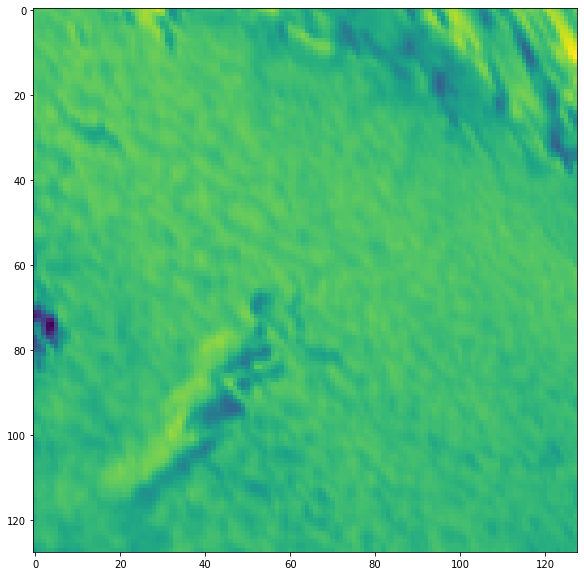

In [17]:
plt.imshow(batch['historical_sat_images'][0, 0])

# Simple ML model

In [18]:
def normalise_images_in_model(images, device):    
    SAT_IMAGE_MEAN = torch.tensor(93.23458, dtype=torch.float, device=device)
    SAT_IMAGE_STD = torch.tensor(115.34247, dtype=torch.float, device=device)
    
    images = images.float()
    images -= SAT_IMAGE_MEAN
    images /= SAT_IMAGE_STD
    return images

In [19]:
CHANNELS = 32
KERNEL = 3


class LitAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.encoder_conv1 = nn.Conv2d(in_channels=1, out_channels=CHANNELS//2, kernel_size=KERNEL)
        self.encoder_conv2 = nn.Conv2d(in_channels=CHANNELS//2, out_channels=CHANNELS, kernel_size=KERNEL)
        self.encoder_conv3 = nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=KERNEL)
        self.encoder_conv4 = nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=KERNEL)

        self.maxpool = nn.MaxPool2d(kernel_size=KERNEL)
        
        self.decoder_conv1 = nn.ConvTranspose2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=KERNEL)
        self.decoder_conv2 = nn.ConvTranspose2d(in_channels=CHANNELS, out_channels=CHANNELS//2, kernel_size=KERNEL)
        self.decoder_conv3 = nn.ConvTranspose2d(in_channels=CHANNELS//2, out_channels=CHANNELS//2, kernel_size=KERNEL)
        self.decoder_conv4 = nn.ConvTranspose2d(in_channels=CHANNELS//2, out_channels=1, kernel_size=KERNEL)
        
    def forward(self, x):
        images = x['historical_sat_images']
        images = normalise_images_in_model(images, self.device)
        
        # Pass data through the network :)
        # ENCODER
        out = F.relu(self.encoder_conv1(images))        
        out = F.relu(self.encoder_conv2(out))       
        out = F.relu(self.encoder_conv3(out))
        out = F.relu(self.encoder_conv4(out))
        out = self.maxpool(out)
        
        # DECODER
        out = F.relu(self.decoder_conv1(out))        
        out = F.relu(self.decoder_conv2(out))        
        out = F.relu(self.decoder_conv3(out))
        out = self.decoder_conv4(out)
        
        return out
    
    def _training_or_validation_step(self, batch, is_train_step):
        y_hat = self(batch)
        y = batch['target_sat_images']
        y = normalise_images_in_model(y, self.device)
        y = y[..., 40:-40, 40:-40]  # Due to the CNN stride, the output image is 48 x 48
        loss = F.mse_loss(y_hat, y)
        tag = "Loss/Train" if is_train_step else "Loss/Validation"
        self.log_dict({tag: loss}, on_step=is_train_step, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=True)
    
    def validation_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [20]:
model = LitAutoEncoder()

In [21]:
trainer = pl.Trainer(gpus=1, max_epochs=400, terminate_on_nan=False)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [22]:
%%time
trainer.fit(model, train_dataloader=dataloader)

/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name          | Type            | Params
--------------------------------------------------
0 | encoder_conv1 | Conv2d          | 160   
1 | encoder_conv2 | Conv2d          | 4.6 K 
2 | encoder_conv3 | Conv2d          | 9.2 K 
3 | encoder_conv4 | Conv2d          | 9.2 K 
4 | maxpool       | MaxPool2d       | 0     
5 | decoder_conv1 | ConvTranspose2d | 9.2 K 
6 | decoder_conv2 | ConvTranspose2d | 4.6 K 
7 | decoder_conv3 | ConvTranspose2d | 2.3 K 
8 | decoder_conv4 | ConvTranspose2d | 145   
--------------------------------------------------
39.6 K    Trainable params
0         Non-trainable params
39.6 K    Total params
0.159     Total estimated model params size (MB)


Epoch 0: : 727it [00:21, 33.41it/s, loss=0.0825, v_num=100]
historical_sat_images has negative values at
['2019-05-24T14:29:00.000000000']
Epoch 0: : 811it [00:23, 34.57it/s, loss=0.0808, v_num=100]
historical_sat_images has negative values at
['2019-05-24T14:29:00.000000000']
Epoch 0: : 4149it [01:32, 44.93it/s, loss=0.141, v_num=100] 
target_sat_images has negative values at
['2018-06-22T01:24:00.000000000']
Epoch 0: : 8230it [02:56, 46.61it/s, loss=0.118, v_num=100] 
target_sat_images has negative values at
['2019-05-24T14:29:00.000000000']
Epoch 0: : 8286it [02:57, 46.59it/s, loss=0.0899, v_num=100]
historical_sat_images has negative values at
['2019-05-24T14:29:00.000000000']
Epoch 0: : 8314it [02:58, 46.60it/s, loss=0.0756, v_num=100]
target_sat_images has negative values at
['2019-05-24T14:29:00.000000000']
Epoch 0: : 8328it [02:58, 46.60it/s, loss=0.0909, v_num=100]
historical_sat_images has negative values at
['2019-05-24T14:29:00.000000000']
Epoch 0: : 10439it [03:42, 46.97it

/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


Epoch 0: : 51414it [17:50, 48.01it/s, loss=0.101, v_num=100]
CPU times: user 18min 24s, sys: 50 s, total: 19min 14s
Wall time: 17min 50s


1